In [1]:
import sys
sys.path.append("../") # go to parent dir
import matplotlib.pyplot as plt
from matplotlib import cm
from lib.graph import grid_tensor
from torch_geometric.nn import graclus, voxel_grid, max_pool
import torch
from torch_geometric.utils import normalized_cut
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.data import Data
import numpy as np

from torch_geometric.nn import knn_interpolate, SplineConv, max_pool_x,  global_mean_pool

from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d as BN
from torch_geometric.nn import PointConv, fps, radius

from lib.datasets import MNIST


In [2]:
grid = grid_tensor((5,5),connectivity=4)
values = np.linspace(0,1,25)
print(values)
grid.x = torch.linspace(0,1,25)
print(grid)

[0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
Data(edge_index=[2, 80], pos=[25, 2], x=[25], y=[1])


## Plotting the grid

In [3]:
def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))


In [4]:
def plot_tensor(d):
    d = d
    plt.figure()
    plt.gca().invert_yaxis()
#     plt.yticks(rotation=90)
    pos_x = d.pos[:,0].numpy()
    pos_y = d.pos[:,1].numpy()
    values =  d.x[:].detach().numpy()
    coo_matrix = d.edge_index 
    colors = [cm.spring(color) for color in values]
    for i in range(d.num_edges):
        ii, jj = coo_matrix[0,i], coo_matrix[1,i]
        plt.plot([pos_y[ii],pos_y[jj]],[pos_x[ii],pos_x[jj]],'k-',alpha=0.1)
    for xx, yy, cc in zip(pos_x, pos_y, colors):
        plt.plot(yy, xx, 'o', color=cc)

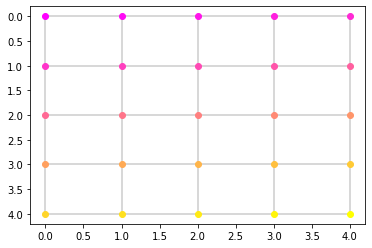

In [5]:
plot_tensor(grid)

In [6]:
transform=T.Cartesian()

In [7]:
a = transform(grid)

In [8]:
grid

Data(edge_attr=[80, 2], edge_index=[2, 80], pos=[25, 2], x=[25], y=[1])

In [9]:
def cluster_grid(grid):
    data = grid
    # data.x = conv1(data.x, data.edge_index, data.edge_attr)
    weight = normalized_cut_2d(data.edge_index, data.pos)
    cluster = graclus(data.edge_index, weight, data.x.size(0))
    data.edge_attr = None
    data.batch = None
    data = max_pool(cluster, data, transform=T.Cartesian(cat=False))
    return data, cluster




data, cluster = cluster_grid(grid)

In [10]:
print(cluster)
# print(grid.pos[0:2][0:2])

tensor([ 0,  1,  1,  3,  3,  0,  6,  7,  8,  8, 10,  6,  7, 13, 13, 10, 16, 16,
        18, 19, 20, 20, 22, 18, 19])


data:  Batch(edge_attr=[48, 2], edge_index=[2, 48], pos=[13, 2], x=[13])
position values:  tensor([[0.5000, 0.0000],
        [0.0000, 1.5000],
        [0.0000, 3.5000],
        [1.5000, 1.0000],
        [1.5000, 2.0000],
        [1.0000, 3.5000],
        [2.5000, 0.0000],
        [2.0000, 3.5000],
        [3.0000, 1.5000],
        [3.5000, 3.0000],
        [3.5000, 4.0000],
        [4.0000, 0.5000],
        [4.0000, 2.0000]])
features values:  torch.Size([13])
number of node:  13


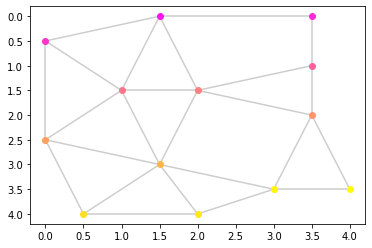

In [11]:
plot_tensor(data)
print('data: ', data)
print('position values: ', data.pos)
print('features values: ',data.x.size())
print('number of node: ',data.num_nodes)

In [12]:
def consecutive_cluster(src):
    unique, inv = torch.unique(src, sorted=True, return_inverse=True)
    perm = torch.arange(inv.size(0), dtype=inv.dtype, device=inv.device)
    perm = inv.new_empty(unique.size(0)).scatter_(0, inv, perm)
    return inv, perm

In [13]:
def recover_grid(source, pos, edge_index, cluster, transform=None):
    cluster, perm = consecutive_cluster(cluster)
    weights = torch.ones((1,len(cluster)))
    Q = torch.zeros((source.num_nodes,cluster.shape[0])).scatter_(0,cluster.unsqueeze(0),weights)
#     print('x.shape, Q.shape',source.x.shape, Q.shape)
    
    if source.x.dim()==1:
        x = source.x.unsqueeze(0).mm(Q).squeeze()
    else:
        # the max dimension is 2
        x= Q.transpose(0,1).mm(source.x)
#     print('x.shape: ',x.shape)
    data = Data(x=x,edge_index=edge_index,pos=pos)
    if transform is not None:
        data = transform(data)
    return data


...recovering grid (upsampling)
grid 1     :  Data(edge_index=[2, 80], pos=[25, 2], x=[25], y=[1])
grid pool  :  Batch(edge_attr=[48, 2], edge_index=[2, 48], pos=[13, 2], x=[13])
grid unpool:  Data(edge_index=[2, 80], pos=[25, 2], x=[25])


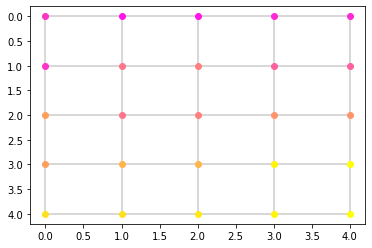

In [14]:
print('...recovering grid (upsampling)')
print('grid 1     : ', grid)
print('grid pool  : ', data)

grid_recovered = recover_grid(data, pos=grid.pos, edge_index=grid.edge_index, cluster=cluster)

print('grid unpool: ',grid_recovered)

plot_tensor(grid_recovered)

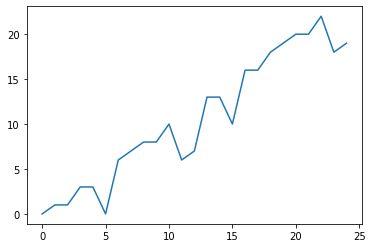

In [15]:
plt.plot(cluster.numpy())

In [16]:
cluster.unique()

tensor([ 0,  1,  3,  6,  7,  8, 10, 13, 16, 18, 19, 20, 22])

## Mnist dataset pool and unpool

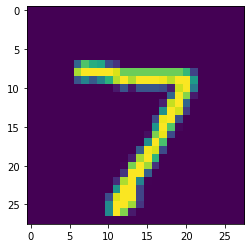

In [17]:
label = 7
number = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,
                   198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,
                   114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,133,254,187,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,9,205,248,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,254,
                   182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,251,240,57,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,221,254,166,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,203,254,219,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,38,254,254,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,31,224,254,115,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,
                   254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,242,254,254,52,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,254,219,40,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,207,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])/255.0
plt.imshow(number.reshape(28,28))

In [18]:
grid = grid_tensor((28,28),connectivity=4)
grid.x = torch.tensor(number.T).float()
print(grid)

Data(edge_index=[2, 3024], pos=[784, 2], x=[784], y=[1])


In [19]:
data, cluster = cluster_grid(grid)

...recovering grid (upsampling)
grid 1     :  Data(edge_index=[2, 3024], pos=[784, 2], x=[784], y=[1])
grid pool  :  Batch(edge_attr=[2026, 2], edge_index=[2, 2026], pos=[425, 2], x=[425])
grid unpool:  Data(edge_index=[2, 3024], pos=[784, 2], x=[784])


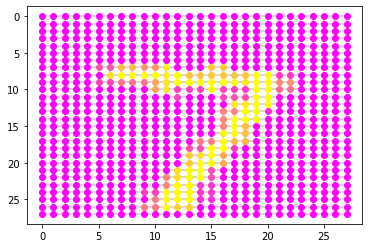

In [20]:
print('...recovering grid (upsampling)')
print('grid 1     : ', grid)
print('grid pool  : ', data)

grid_recovered = recover_grid(data, pos=grid.pos, edge_index=grid.edge_index, cluster=cluster)

print('grid unpool: ',grid_recovered)

plot_tensor(grid_recovered)

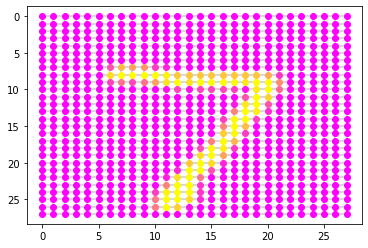

In [21]:
plot_tensor(grid)

## Network definitino

In [24]:
class DataLoader_seven(object):
    
    def __init__(self):
        ## make the 7
        self.label = 7
        self.number = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,
                           198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,
                           114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,133,254,187,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,9,205,248,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,254,
                           182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,251,240,57,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,221,254,166,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,203,254,219,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,38,254,254,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,31,224,254,115,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,
                           254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,242,254,254,52,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,254,219,40,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,207,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])/255.0
        self.mask = (self.number>0.2)
    
    def __len__(self):
        return 10
    
    def __getitem__(self,idx):
        grid = grid_tensor((28,28),connectivity=4)
        grid.x = torch.tensor(self.number.T).float()
        grid.batch = torch.zeros(grid.num_nodes).long()
        grid = transform(grid)
        grid.y = torch.tensor([self.mask]).float().transpose(0,1)
        return grid
    
    def __iter__(self):
        for i in range(10):
            grid = self.__getitem__(i)
            yield grid

In [25]:
class DataLoader(object):
    def __init__(self):
        self.dataset = MNIST()
        self.test_dataset = self.dataset.train
        self.train_dataset = self.dataset.test

    def __len__(self):
        return 10
    
    def __getitem__(self,idx):
        image, mask = self.train_dataset[idx]
        grid = grid_tensor((28,28),connectivity=4)
        grid.x = torch.tensor(image.reshape(28*28)).float()
        grid.batch = torch.zeros(grid.num_nodes).long()
        grid = transform(grid)
        grid.y = torch.tensor([mask.reshape(28*28)]).float().transpose(0,1)
        return grid
    
    def __iter__(self):
        for i in range(10):
            grid = self.__getitem__(i)
            yield grid

In [26]:
dataloader = DataLoader()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/M2NIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/M2NIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/M2NIST/t10k-images-idx3-ubyte.gz
Extracting data/M2NIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


data @  0  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  1  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  2  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  3  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  4  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  5  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  6  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  7  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  8  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  9 

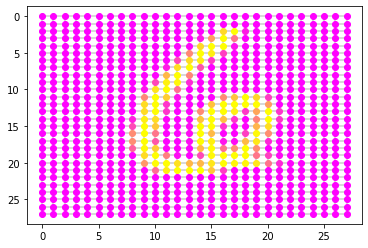

In [27]:
data = dataloader[123]
plot_tensor(data)
for i, d in enumerate(dataloader):
    print('data @ ' , i , ' : ', data)


In [28]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(1, 32, dim=2, kernel_size=5)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=5)
        self.conv3 = SplineConv(64, 32, dim=2, kernel_size=5)
        self.conv4 = SplineConv(32, 1, dim=2, kernel_size=5)


    def forward(self, data):
        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_2d(data.edge_index, data.pos)
        cluster1 = graclus(data.edge_index, weight, data.x.size(0))
        pos1 = data.pos
        edge_index1 = data.edge_index
        data = max_pool(cluster1, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_2d(data.edge_index, data.pos)
        pos2 = data.pos
        edge_index2 = data.edge_index
        cluster2 = graclus(data.edge_index, weight, data.x.size(0))
        data = max_pool(cluster2, data, transform=T.Cartesian(cat=False))

        # upsample
        data = recover_grid(data, pos2, edge_index2, cluster2, transform=T.Cartesian(cat=False))
        data.x = F.elu(self.conv3(data.x, data.edge_index, data.edge_attr))
        
        data = recover_grid(data, pos1, edge_index1, cluster1, transform=T.Cartesian(cat=False))
        data.x = F.elu(self.conv4(data.x, data.edge_index, data.edge_attr))
        
        x, batch = data.x, torch.zeros(data.num_nodes)
        
        return F.sigmoid(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

In [30]:
dataloader = DataLoader()

Extracting data/M2NIST/train-images-idx3-ubyte.gz
Extracting data/M2NIST/train-labels-idx1-ubyte.gz
Extracting data/M2NIST/t10k-images-idx3-ubyte.gz
Extracting data/M2NIST/t10k-labels-idx1-ubyte.gz


In [31]:
model.train()
for d in dataloader:
#     print(d)
    pred = model(d)
    optimizer.zero_grad()
    loss = criterion(pred, d.y)
    loss.backward()
    optimizer.step()
    print('loss: ' , loss.item())
    

/home/ari/miniconda3/envs/th/lib/python3.7/site-packages/torch_geometric/nn/conv/spline_conv.py:103: UserWarning: We do not recommend using the non-optimized CPU version of SplineConv. If possible, please convert your data to the GPU first.
  warnings.warn('We do not recommend using the non-optimized CPU '
/home/ari/miniconda3/envs/th/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss:  0.695428729057312
loss:  0.6815562844276428
loss:  0.6121915578842163
loss:  0.5993759632110596
loss:  0.494112491607666
loss:  0.4239177405834198
loss:  0.4658321440219879
loss:  0.4550620913505554
loss:  0.5145567059516907
loss:  0.5147143602371216


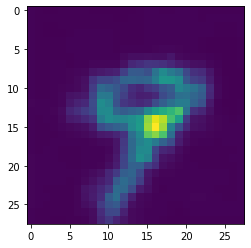

In [39]:
pred_mask = (pred > 0.1).float()
plt.imshow(pred.detach().numpy().reshape(28,28))

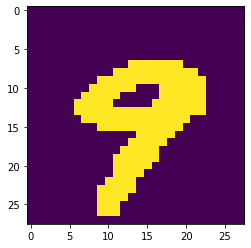

In [47]:
plt.imshow(d.y.detach().numpy().reshape(28,28))